# Additional Usage Examples

Functions and information that **are not used** in the main code, but can be useful later

## Imports

In [2]:
import re
import random
import os, subprocess
from tqdm import tqdm
from copy import deepcopy
from typing import Optional, Tuple, List

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch as th
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import datasets, transforms
from torchvision.datasets.mnist import MNIST

from sklearn.datasets import make_swiss_roll
from sklearn.utils import shuffle

from diffusion import DDPM, ForwardDiffusion, ReverseDiffusion, get_beta_schedule
from unet import LabeledDataset, get_labeled_data_loader, MyUNet
from smallnet import LinearNet, Net, split_dataset


MODELS_DIR = "models"
if not os.path.exists(MODELS_DIR):
    os.mkdir(MODELS_DIR)
SAVE_DPPM_MNIST_PATH = f"{MODELS_DIR}/ddpm_mnist.pt"

## Downloads

In [7]:
!pip install -U gdown

  Attempting uninstall: gdown
    Found existing installation: gdown 4.7.3
    Uninstalling gdown-4.7.3:
      Successfully uninstalled gdown-4.7.3


In [8]:
# Downloading pretrained model
!gdown -O "models/ddpm_mnist.pt" "https://drive.google.com/uc?id=1fSPB08M6aBNmhjRgSn3qpdq5hXl1Xhao"

Downloading...
From: https://drive.google.com/uc?id=1fSPB08M6aBNmhjRgSn3qpdq5hXl1Xhao
To: /content/models/ddpm_mnist.pt
100% 5.26M/5.26M [00:00<00:00, 99.6MB/s]


## Denoising Diffusion Probabilistic Model (DDPM)

In [9]:
T = 1000
BATCH_SIZE = 1024
LR = 0.01
WEIGHT_DECAY = 0.0
N_ITERS = 5000

device = th.device("cuda" if th.cuda.is_available() else "cpu")

model_dif = MyUNet()

ddpm = DDPM.from_pretrained(model_dif, SAVE_DPPM_MNIST_PATH).to(device)

/content/diffusion.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer("clip_x0", th.tensor(clip_x0, dtype=bool))


## Downloading dataset

In [3]:
dataset = MNIST("./datasets", download=True, train=True)
X = dataset.data.numpy().astype("float32")[:, None]
y = dataset.targets.numpy()

100%|██████████| 9912422/9912422 [00:00<00:00, 299036993.24it/s]

Extracting ./datasets/MNIST/raw/train-images-idx3-ubyte.gz to ./datasets/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 36149117.82it/s]


Extracting ./datasets/MNIST/raw/train-labels-idx1-ubyte.gz to ./datasets/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 154728312.79it/s]

Extracting ./datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to ./datasets/MNIST/raw




100%|██████████| 4542/4542 [00:00<00:00, 11716192.35it/s]


Extracting ./datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./datasets/MNIST/raw



In [4]:
def show_images(images, ys, title=""):
    """Shows the provided images as sub-pictures in a square"""
    if type(images) is th.Tensor:
        images = images.detach().cpu().numpy()
        ys = ys.detach().cpu().numpy()

    rows = int(len(images) ** (1 / 2))
    cols = round(len(images) / rows)
    fig = plt.figure(figsize=(cols*2, rows*2))

    idx = 0
    for r in range(rows):
        for c in range(cols):
            fig.add_subplot(rows, cols, idx + 1)

            if idx < len(images):
                plt.imshow(images[idx][0], cmap="gray")
                plt.title(f"{int(ys[idx])}")
                plt.tick_params(bottom = False, labelbottom=False)
                idx += 1
    fig.suptitle(title, fontsize=30)
    plt.show()


def show_first_batch(loader, batch_size=16):
    for batch in loader:
        show_images(batch["x"][:batch_size], batch["y"][:batch_size], "Images in the first batch")
        break

In [5]:
def mnist_to_train_range(X):
    return ((X.astype("float32") / 255.) - 0.5) * 2

def mnist_from_train_range(X):
    return (((X.astype("float32") + 1.0) / 2) * 255.).astype("int")


mnist_loader = get_labeled_data_loader(mnist_to_train_range(X), y, batch_size=64)

## Print generated numbers

100%|██████████| 1000/1000 [00:51<00:00, 19.27it/s]


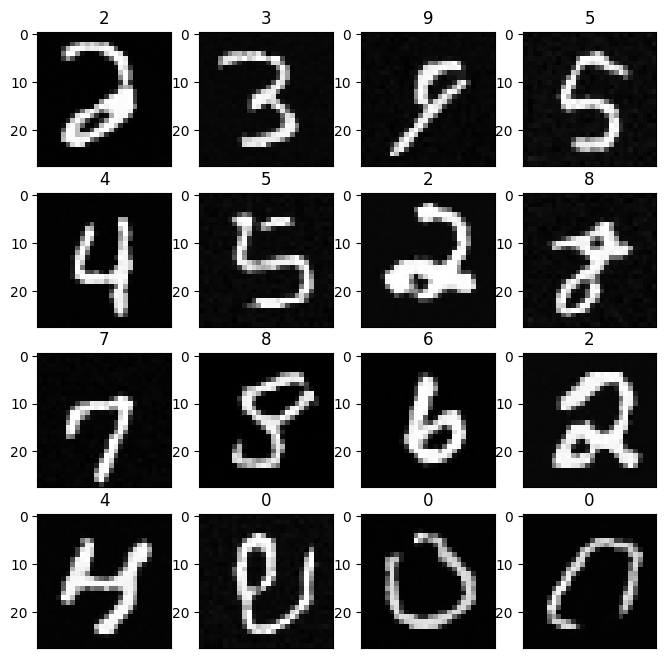

In [10]:
num_samples = 16
ys = th.randint(10, size=(num_samples,), device=device)
Xs, ys = ddpm.sample(y=ys)
show_images(Xs, ys)

## Print an image on a specific step of Diffusion

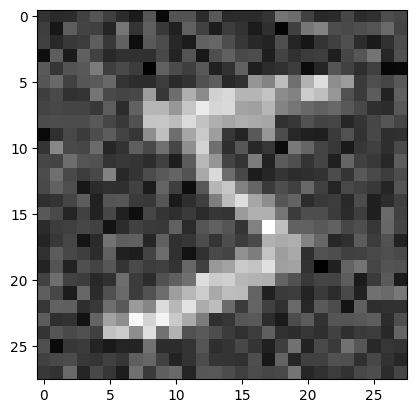

In [11]:
T = 1000
t_up = 150

images = next(iter(mnist_loader))["x"][:1, 0]

forward_diffusion = ForwardDiffusion(betas=get_beta_schedule(T))
plot_n_steps = 1
noised_samples = []

x = forward_diffusion.q_sample(
    x0=images,
    t=(th.ones(images.shape[0], device=images.device) * (t_up)).long(),
)

fig = plt.figure
plt.imshow(x.reshape((28,28)), cmap='gray')
plt.show()

## Print several images on a specific steps of Diffusion

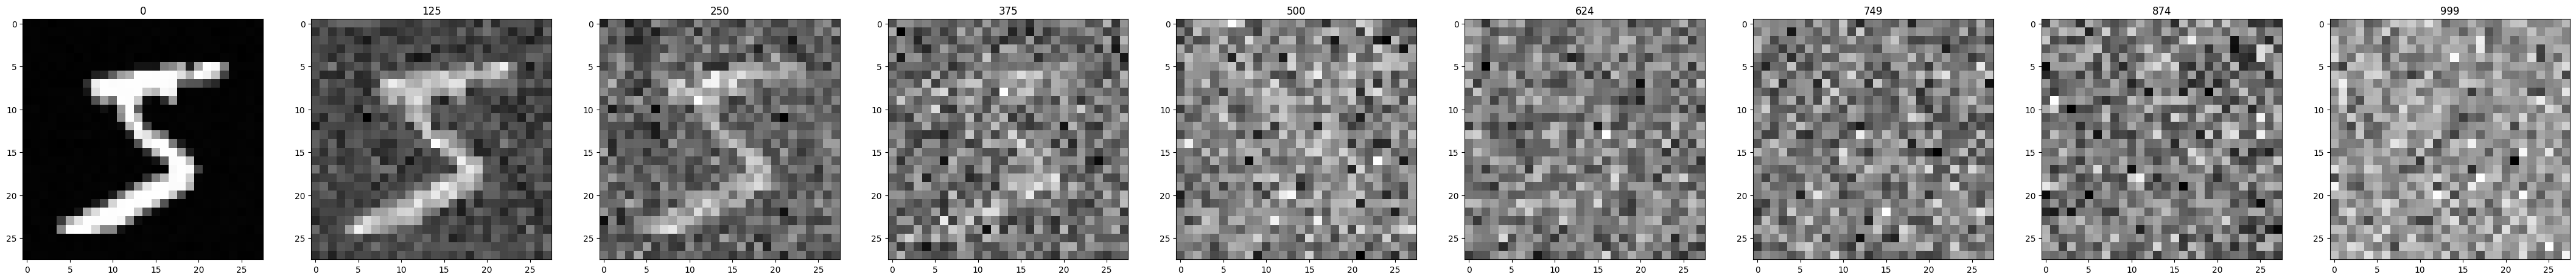

In [12]:
forward_diffusion = ForwardDiffusion(betas=get_beta_schedule(1000))
plot_n_steps = 9
noised_samples = []
images = next(iter(mnist_loader))["x"][:1, 0]
_, axs = plt.subplots(1, plot_n_steps, figsize=(6 * plot_n_steps, 6))
t_to_plot = list(np.round(np.linspace(0, forward_diffusion.num_timesteps - 1, num=plot_n_steps)).astype("int"))
for i,t in enumerate(t_to_plot):
    x = forward_diffusion.q_sample(
        x0=images,
        t=(th.ones(images.shape[0], device=images.device) * t).long(),
    )
    axs[i].imshow(x[0], cmap="gray")
    axs[i].set(title=t)
    noised_samples.append(x[0])

In [13]:
num_samples = 1
k = 1
t_up = t_to_plot[k] # t_up = 125
Xs = noised_samples[k]
Xs = Xs.reshape([num_samples,1,28,28])
Xs = Xs.to(device)
ys = th.tensor([5] * num_samples).to(device)
print("Moment of time:", t_up)

t = th.tensor([t_up] * num_samples).to(device)
feature_map = model_dif.get_features(x=Xs, t=t, y=ys)
print(feature_map.shape)

Moment of time: 125
torch.Size([1, 80])


## Additional function

This code can be optionally included in `train_model()` so to save only the best trained model from all epochs
            
            new_ac = true_pred / total
            if new_ac > best_ac:
                best_ac = new_ac
                th.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'train_loss_history': loss_list,
                    }, PATH)